In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls /content/gdrive/My\ Drive/eva-04/S11/* 

We'll need to update our path to import from Drive.

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/eva-04/S11/')

SHOW PARAMETERS

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize
from albumentations.pytorch import ToTensor
from models import ResnetA11 as resnetA11
from transformations import CIFARModel11_Alb as cifar

from utils.global_fun import show_summary, run_model_with_entropy,  draw_accuracy_loss_change_graps, plot_accuracy_loss_graphs

import importlib
importlib.reload(resnetA11)
importlib.reload(cifar)


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = resnetA11.ResNetA11().to(device)
criterion = torch.nn.CrossEntropyLoss()

cifar_model = cifar.CIFARModel11_Alb(model,criterion,None,None)

SEED = 1
# CUDA?
print("CUDA Available?", use_cuda)

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
#train_loader = torch.utils.data.DataLoader(g_train, **dataloader_args)

# test dataloader
#test_loader = torch.utils.data.DataLoader(g_test, **dataloader_args)
#import images as im
#import random
#X,Y,names = im.get_data('cifar-10-batches-py/data_batch_1')
import numpy as np
import matplotlib.pyplot as plt
import os
#importlib.reload(im)
#for x in range(100):
#  im.visualize_image(X,Y,names,random.randint(1,10000),'/content/gdrive/My Drive/eva-04/S9/images')
show_summary(cifar_model,input_size=(3,32,32))


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
cuda
CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]      

FIND LR_MAX USING LR FINDER

  pip install torch-lr-finder -v --global-option="amp"
  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
Max Accuracy = 20.8984375 at LR = 0.03801893963205612


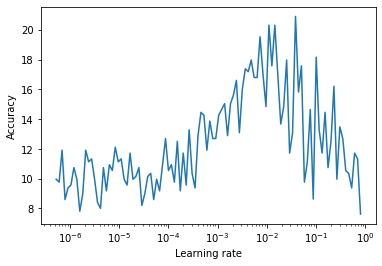

In [4]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from lr_finder import LRFinder as lrfinder

#model1 = resnet_a11.ResNetA11().to(device)
criterion = nn.CrossEntropyLoss()
importlib.reload(lrfinder)
optimizer = optim.SGD(cifar_model.m_model.parameters(), lr=1e-7)
lr_finder = lrfinder.LRFinder(cifar_model.m_model, optimizer, criterion, device="cuda")
lr_finder.range_test(cifar_model.m_train_loader, end_lr=100, num_iter=150, step_mode="exp")
lr_finder.plot(skip_end=0, accuracy_flag = True)
lr_finder.reset()

ONECYLE LR

In [5]:
from utils.global_fun import test_model
from utils.global_fun import train_model
from utils.global_fun import show_summary, run_model_with_entropy,  draw_accuracy_loss_change_graps, plot_accuracy_loss_graphs

import utils.global_fun as fun
from models import ResnetA11 as resnet_a11
from transformations import CIFARModel11_Alb as cifar1
import OneCycleLR_A11 as oneCycle 


import importlib
importlib.reload(resnet_a11)
importlib.reload(oneCycle)
importlib.reload(cifar1)
importlib.reload(fun) 
#from torch.optim.lr_scheduler import OneCycleLR
criterion = torch.nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-04)
lr_max = 0.008317637711026704
lr_min = lr_max / 10
batch_size = 512
iterations = 50000/batch_size

scheduler = oneCycle.OneCycleLR_A11(optimizer, 24, iterations, (lr_min, lr_max), (0.8, 0.95))
#cifar_model(optimizer,scheduler)

cifar_model.setOptimizer(optimizer)
cifar_model.setScheduler(scheduler)



Files already downloaded and verified
Files already downloaded and verified


DRAW CyclicLR PLOT

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def draw_cyclic_lr_graph(lr_min,lr_max,step,iterations):
  #lr_min,lr_max are in y direction
  # each triangle to be plot with 3 points (0,lr_min),(0+step,lr_max),(2*step,lr_max) 
  x_points = [0]
  y_points = [lr_min]
  last_step=step
  max = True
  plt.figure(figsize=(20,10))
  
  for x in range(iterations):
    x_points.append(last_step)
    last_step= last_step + step
    if(max == True):
      y_points.append(lr_max)
      max = False
    else:
      y_points.append(lr_min)
      max = True
  #for i in range(iterations-1):
    plt.plot(x_points, y_points, 'bo-')
    #print(x_points[i],'::',y_points[i])
  
  plt.xlabel('Iterations')
  plt.ylabel('Lr Range')
  plt.show()

import math
def draw_cyclic_lr_graph1(lr_min,lr_max,batch_size,max_num_cycles,no_of_images):
  #lr_min,lr_max are in y direction
  # each triangle to be plot with 3 points (0,lr_min),(0+step,lr_max),(2*step,lr_max) 
  x_points = []
  y_points = []
  plt.figure(figsize=(20,10))
  cycle_count =0
  iteration =0
  batch_iterations = no_of_images/batch_size
  step_size = 10 *batch_iterations # between 2 to 10 iterations

  while(cycle_count <= max_num_cycles):
    cycle_count = math.floor(1+iteration/(2*step_size))
    x = abs((iteration/step_size) - (2*(cycle_count))+1)
    lr_t = lr_min + ((lr_max - lr_min)*(1.0 - x))
    y_points.append(lr_t)
    x_points.append(iteration)
    iteration = iteration +1

  plt.plot(x_points, y_points, '-')
    #print(x_points[i],'::',y_points[i])
  
  plt.xlabel('Iterations')
  plt.ylabel('Lr Range')
  plt.show()


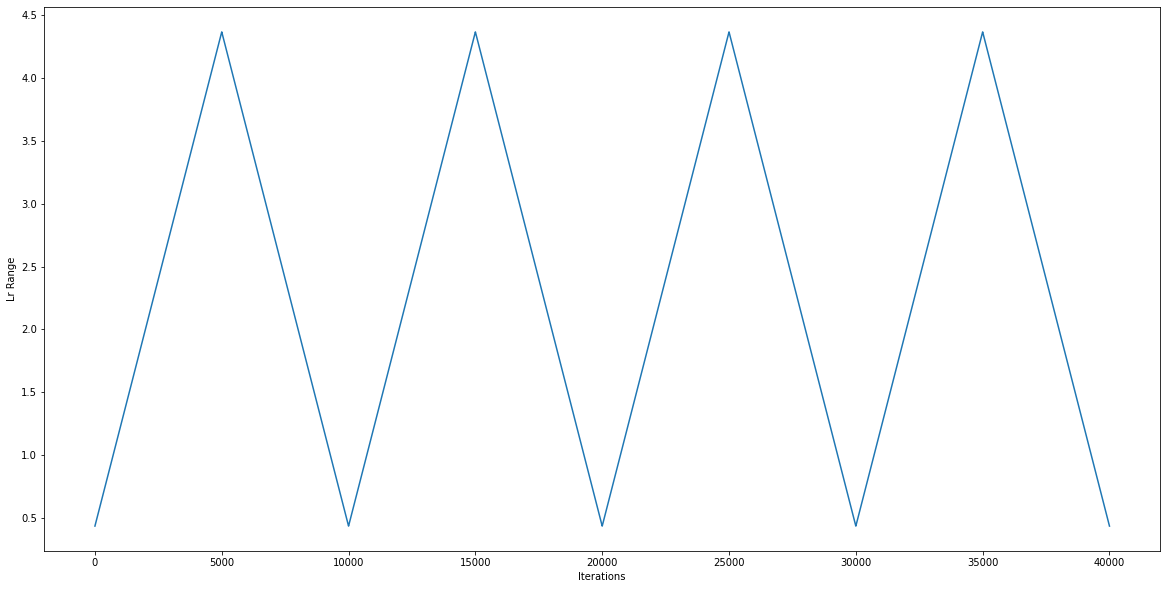

In [60]:
draw_cyclic_lr_graph1(0.4365,4.365,100,4,50000)

RUNNING WITH REGULARIZATION

In [6]:
run_model_with_entropy(cifar_model, device, doL1= 0, doL2=0, LAMBDA=0, EPOCHS=30)
for param_group in cifar_model.m_optimizer.param_groups:
  print(param_group['lr'])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 0


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 3805/10000 (38.05%)

EPOCH: 1
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 1


Loss=1.3810094594955444 Batch_id=97 Accuracy=41.84: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5122/10000 (51.22%)

EPOCH: 2
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 2


Loss=1.2846323251724243 Batch_id=97 Accuracy=51.02: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5631/10000 (56.31%)

EPOCH: 3
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 3


Loss=1.0674234628677368 Batch_id=97 Accuracy=57.30: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 6213/10000 (62.13%)

EPOCH: 4
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 4


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 6778/10000 (67.78%)

EPOCH: 5
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 5


Loss=0.9599289894104004 Batch_id=97 Accuracy=65.19: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 6990/10000 (69.90%)

EPOCH: 6
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 6


Loss=0.8549212217330933 Batch_id=97 Accuracy=69.11: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7182/10000 (71.82%)

EPOCH: 7
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 7


Loss=0.8038296699523926 Batch_id=97 Accuracy=71.10: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7632/10000 (76.32%)

EPOCH: 8
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 8


Loss=0.7324952483177185 Batch_id=97 Accuracy=73.06: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7905/10000 (79.05%)

EPOCH: 9
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 9


Loss=0.7546557188034058 Batch_id=97 Accuracy=74.08: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7879/10000 (78.79%)

EPOCH: 10
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 10


Loss=0.7743036150932312 Batch_id=97 Accuracy=76.08: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8182/10000 (81.82%)

EPOCH: 11
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 11


Loss=0.5890402793884277 Batch_id=97 Accuracy=76.82: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8158/10000 (81.58%)

EPOCH: 12
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 12


Loss=0.6287622451782227 Batch_id=97 Accuracy=77.70: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8259/10000 (82.59%)

EPOCH: 13
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 13


Loss=0.5371396541595459 Batch_id=97 Accuracy=79.20: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8229/10000 (82.29%)

EPOCH: 14
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 14


Loss=0.5559048056602478 Batch_id=97 Accuracy=79.76: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8310/10000 (83.10%)

EPOCH: 15
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 15


Loss=0.5224443078041077 Batch_id=97 Accuracy=80.72: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8365/10000 (83.65%)

EPOCH: 16
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 16


Loss=0.4574623703956604 Batch_id=97 Accuracy=81.44: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8294/10000 (82.94%)

EPOCH: 17
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 17


Loss=0.5993673801422119 Batch_id=97 Accuracy=81.96: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8466/10000 (84.66%)

EPOCH: 18
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 18


Loss=0.48495057225227356 Batch_id=97 Accuracy=82.66: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8404/10000 (84.04%)

EPOCH: 19
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 19


Loss=0.471103310585022 Batch_id=97 Accuracy=83.21: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8650/10000 (86.50%)

EPOCH: 20
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 20


Loss=0.6149613261222839 Batch_id=97 Accuracy=83.64: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8419/10000 (84.19%)

EPOCH: 21
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 21


Loss=0.4943375885486603 Batch_id=97 Accuracy=84.37: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8603/10000 (86.03%)

EPOCH: 22
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 22


Loss=0.4508573114871979 Batch_id=97 Accuracy=84.94: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8672/10000 (86.72%)

EPOCH: 23
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 23


Loss=0.36218246817588806 Batch_id=97 Accuracy=85.17: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8750/10000 (87.50%)

EPOCH: 24
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 24


Loss=0.3518814444541931 Batch_id=97 Accuracy=86.01: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8636/10000 (86.36%)

EPOCH: 25
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 25


Loss=0.33196282386779785 Batch_id=97 Accuracy=86.11: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8757/10000 (87.57%)

EPOCH: 26
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 26


Loss=0.3507779538631439 Batch_id=97 Accuracy=86.86: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8730/10000 (87.30%)

EPOCH: 27
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 27


Loss=0.3748365044593811 Batch_id=97 Accuracy=87.10: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8678/10000 (86.78%)

EPOCH: 28
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 28


Loss=0.30506521463394165 Batch_id=97 Accuracy=87.30: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8759/10000 (87.59%)

EPOCH: 29
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 29


Loss=0.3076881766319275 Batch_id=97 Accuracy=87.60: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average loss: 0.0008, Accuracy: 8765/10000 (87.65%)

0.008317637711026704


In [8]:
run_model_with_entropy(cifar_model, device, doL1= 0, doL2=0, LAMBDA=0, EPOCHS=15,start=25)
for param_group in cifar_model.m_optimizer.param_groups:
  print('lr =', param_group['lr'])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 25
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 0


Loss=0.32890501618385315 Batch_id=97 Accuracy=87.70: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8734/10000 (87.34%)

EPOCH: 26
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 1


Loss=0.3067866861820221 Batch_id=97 Accuracy=88.10: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8854/10000 (88.54%)

EPOCH: 27
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 2


Loss=0.32864370942115784 Batch_id=97 Accuracy=88.30: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8813/10000 (88.13%)

EPOCH: 28
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 3


Loss=0.2927706241607666 Batch_id=97 Accuracy=88.56: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8917/10000 (89.17%)

EPOCH: 29
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 4


Loss=0.32606807351112366 Batch_id=97 Accuracy=88.95: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8920/10000 (89.20%)

EPOCH: 30
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 5


Loss=0.3669281601905823 Batch_id=97 Accuracy=89.18: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8916/10000 (89.16%)

EPOCH: 31
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 6


Loss=0.2637348473072052 Batch_id=97 Accuracy=89.51: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8875/10000 (88.75%)

EPOCH: 32
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 7


Loss=0.3205905556678772 Batch_id=97 Accuracy=89.73: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8863/10000 (88.63%)

EPOCH: 33
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 8


Loss=0.2839478552341461 Batch_id=97 Accuracy=90.10: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8771/10000 (87.71%)

EPOCH: 34
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 9


Loss=0.2755388915538788 Batch_id=97 Accuracy=90.18: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8901/10000 (89.01%)

EPOCH: 35
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 10


Loss=0.26028871536254883 Batch_id=97 Accuracy=90.25: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8928/10000 (89.28%)

EPOCH: 36
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 11


Loss=0.3354491591453552 Batch_id=97 Accuracy=90.47: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8865/10000 (88.65%)

EPOCH: 37
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 12


Loss=0.24278602004051208 Batch_id=97 Accuracy=90.80: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8845/10000 (88.45%)

EPOCH: 38
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 13


Loss=0.2339516580104828 Batch_id=97 Accuracy=91.14: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8930/10000 (89.30%)

EPOCH: 39
L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 14


Loss=0.24603688716888428 Batch_id=97 Accuracy=91.20: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]



Test set: Average loss: 0.0007, Accuracy: 8938/10000 (89.38%)

lr = 0.008317637711026704


Training and Validation Accuracy Change

0  and  30


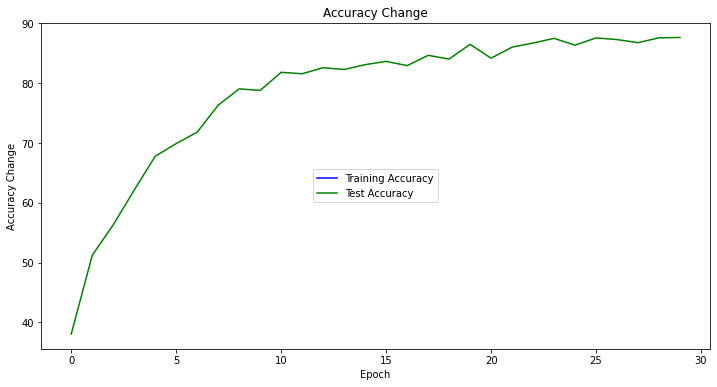

In [7]:

import utils.global_fun as fun
importlib.reload(fun)

importlib.reload(fun)
from utils.global_fun import plot_accuracy_loss_graphs, draw_accuracy_graph
print(len(cifar_model.m_train_acc),' and ',len(cifar_model.m_test_acc))
draw_accuracy_graph(cifar_model,'Accuracy Change')

SAVE MODEL

In [0]:
state = {
    'epoch': 150,
    'state_dict': cifar_model.m_model.state_dict(),
    'optimizer': cifar_model.m_optimizer.state_dict()
}

filepath = "/content/gdrive/My Drive/eva-04/S11/saved_model"

torch.save(cifar_model.m_model.state_dict(), open(os.path.join(filepath, 'model.pt'), 'wb'))
torch.save(cifar_model.m_optimizer.state_dict(), open(os.path.join(filepath, 'optimizer.pt'), 'wb'))
torch.save(state, open(os.path.join(filepath, 'savedmodel'), 'wb'))

#model.load_state_dict(state['state_dict'])
#optimizer.load_state_dict(state['optimizer'])
#model = torch.load(filepath)


LR FINDER

Increases the learning rate in an exponential manner and computes the training loss for each learning rate. lr_finder.plot() plots the training loss versus logarithmic learning rate.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
Max Accuracy = 95.5078125 at LR = 0.004786300923226385


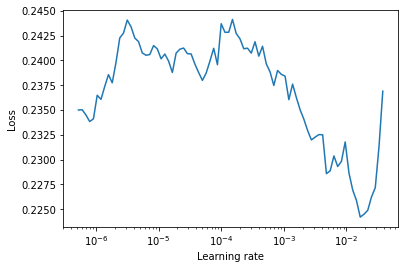

In [9]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from lr_finder import LRFinder as lrfinder

model = resnet_a11.ResNetA11().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(cifar_model.m_model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrfinder.LRFinder(cifar_model.m_model, optimizer, criterion, device="cuda")
lr_finder.range_test(cifar_model.m_train_loader, end_lr=100, num_iter=150, step_mode="exp")
lr_finder.plot()

lr_finder.reset()

#model = rc10.resnet56()
#lr_finder = LRFinder(model,cifar_model.m_optimizer,cifar_model.m_criterion, device)
#lr_finder.range_test(cifar_model.m_trainloader, end_lr=100, num_iter=100, step_mode="exp")


GRADCAM VISUALIZATION

In [0]:

def plot_gradcam(cam_data, pred_data, classes, plot_name):
    fig, axs = plt.subplots(len(cam_data), 2, figsize=(4, 60))

    for idx in range(len(cam_data)):
        label = classes[pred_data[idx]['label']]
        prediction = classes[pred_data[idx]['prediction']]

        axs[idx][0].axis('off')
        axs[idx][0].set_title(f'Image: {idx + 1}\nLabel: {label}')
        axs[idx][0].imshow(cam_data[idx]['image'])

        axs[idx][1].axis('off')
        axs[idx][1].set_title(f'GradCAM: {idx + 1}\nPrediction: {prediction}')
        axs[idx][1].imshow(cam_data[idx]['result']['layer3'])
    fig.tight_layout()
    fig.subplots_adjust(top=1.1)
    fig.savefig(plot_name, bbox_inches='tight')

Mode set to GradCAM.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


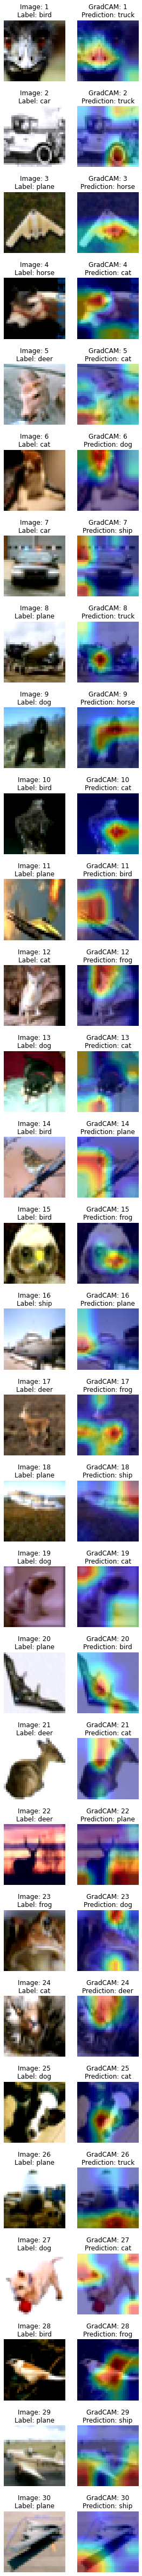

In [11]:
from gradcam import visualize as vs

layers = ['layer3']
grad_cam = vs.GradCAMView(
    cifar_model.m_model, layers,
    device, cifar.mean(), cifar.std()
)

from gradcam import visualize as vs 
importlib.reload(vs)

views = grad_cam([x['image'] for x in cifar_model.m_incorrect_samples])
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(views, cifar_model.m_incorrect_samples, classes, 'prediction_gradcam.png')